# Entites
gpe = Geopolitical Entity
eve = Event
org = Organization
tim = Time indicator
geo = Geographical Entity
nat = Natural Phenomenon
art = Artifact
per = Person


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Load Data

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/code/Named-Entity-Recognition-using-LSTMs-with-Keras/ner_dataset.csv', encoding='latin1')
data = data.fillna (method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


Explore Data Distribution

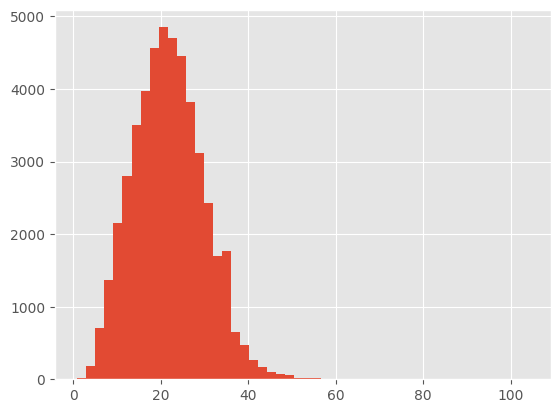

In [ ]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

Vocab

In [ ]:
words = list(set(data["Word"].values))
words.append ("ENDPAD" )
num_words = len(words)

Num Tags

In [ ]:
num_tags = len(list(set (data["Tag"].values) ))

Get Sentences w/ tags

In [ ]:
sentences = [s for s in data.groupby("Sentence #").apply(lambda s: [(w, p, t) for w, p, t in zip( s["Word"].values.tolist(),
                                                          s["POS"].values.tolist(),
                                                          s["Tag"].values.tolist()))]

word mappings

In [ ]:
word2idx = {w: i+1 for i, w in enumerate(words) }
tag2idx = {t: i for i, t, in enumerate(tags)}

Pad Sequences



In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences (maxlen=max_len, sequences=X, padding='post', value=num_words-1)
y = [[tag2idx [w[2]] for w in s] for s in sentences]
y = pad_sequences (maxlen=max_len, sequences=y, padding='post', value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

Split Data

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

Build Bidirectional LSTM Model

In [ ]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [ ]:
input_word = Input(shape=(max_len,))
model = Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len) (input_word)
model = SpatialDropout1D (0.1) (model)
model = Bidirectional(LSTM(units=100, return_sequences=True, recurrent_dropout=0.1)) (model)
out = TimeDistributed(Dense (num_tags, activation='softmax')) (model)
model = Model (input_word, out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758950   
                                                                 
 spatial_dropout1d (Spatial  (None, 50, 50)            0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 50, 200)           120800    
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 50, 17)            3417      
 ributed)                                                        
                                                             

In [ ]:
model.compile(optimizer='adam',
              loss= "categorical_crossentropy",
              metrics=["accuracy"])

Train

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
early_stopping = EarlyStopping (monitor='val_accuracy', patience=1, verbose=0, mode='max', restore_best_weights=False)
callbacks = [PlotLossesCallback(), early_stopping]
history = model.fit(
  x_train,
  np.array(y_train),
  validation_split=0.2,
  batch_size=32
)

1080/1080 [==============================] - 453s 411ms/step - loss: 0.1905 - accuracy: 0.9573 - val_loss: 0.0666 - val_accuracy: 0.9810


### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(x_test, np.array(y_test))

150/150 [==============================] - 5s 32ms/step - loss: 0.0697 - accuracy: 0.9806


[0.06965266168117523, 0.9806255102157593]

In [ ]:
i = np.random.randint(0, x_test.shape [0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)

y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t {}".format("Word", "True", "Pred" ))
print("-"*30)
for w, true, pred in zip(x_test[i], y_true, p[0]):
  print("{:15}{}\t{}".format(words [w-1], tags[true], tags[pred]))

1/1 [==============================] - 0s 62ms/step
Word           True 	 Pred
------------------------------
North          B-geo	B-geo
Korea          I-geo	I-geo
has            O	O
called         O	O
Vice           O	O
President      B-per	B-per
Dick           I-per	I-per
Cheney         I-per	I-per
a              O	O
"              O	O
bloodthirsty   O	O
beast          O	O
"              O	O
and            O	O
said           O	O
his            O	O
comments       O	O
describing     O	O
ruler          O	O
Kim            B-per	B-per
Jong-il        I-per	I-per
as             O	O
"              O	O
irresponsible  O	O
"              O	O
could          O	O
keep           O	O
Pyongyang      O	B-geo
away           O	O
from           O	O
future         O	O
nuclear        O	O
negotiations   O	O
.              O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt        O	O
disrupt      